<a href="https://colab.research.google.com/github/jiinpark21/ESAA_24-1/blob/main/10%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C_0506.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 머신러닝 완벽가이드 ch5. 6~7

pg. 319-334

# [Chapter 5] 회귀


## 5-6. 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷

### 규제 선형 모델의 개요

RSS 최소화만 고려하면, 학습 데이터에 지나치게 맞추게 되고 회귀 계수가 쉽게 커짐 -> 변동성 증가

[비용(cost) 함수의 목표]

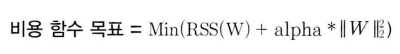

- alpha : 학습 데이터 적합 정도, 회귀 계수 값의 크기를 제어하는 튜닝 파라미터

  - alpha가 매우 작은 값 : 비용 함수는 기존과 동일한 Min(RSS(W) + 0)
  - alpha가 매우 큰 값 : 비용 함수가 RSS(W)에 비해 alpha*||W|| 값이 너무 커지게 됨 -> W 값을 작게 만들어야 cost를 최소화할 수 있음

- 규제 : 비용 함수에 alpha 값으로 페널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식

  - L2 : W의 제곱에 대해 페널티 부여 (릿지 회귀)
  - L1 : W의 절댓값에 대해 페널티를 부여 (라쏘 회귀) / 영향력이 크지 않은 회귀 계수 값을 0으로 변환


### 릿지 회귀

Ridge 클래스
- alpha : 주요 생성 파라미터

In [ ]:
# 보스턴 주택 가격
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
%matplotlib inline

# boston 데이터 세트 로드
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])

# feature name이 없으므로 따로 지정해줘야 함.
feature_names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX' ,'PTRATIO', 'B' ,'LSTAT', 'PRICE']

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston, columns=feature_names)

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# alpha=10으로 설정해 릿지 회귀 수행.
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print(' 5 folds 의 개별 RMSE scores: ', np.round(rmse_scores, 3))
print(' 5 folds 의 평균 RMSE scores: {0:.3f}'.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
 5 folds 의 개별 RMSE scores:  [3.38  4.929 5.305 8.637 5.34 ]
 5 folds 의 평균 RMSE scores: 5.518


- 규제가 없는 LinearRegression의 RMSE보다 더 뛰어난 예측 성능을 보임

In [ ]:
# 릿지에 사용될 alpha 파라미터의 값을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함.
for alpha in alphas:
  ridge = Ridge(alpha = alpha)

  # cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
  neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
  avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
  print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

alpha 0 일 때 5 folds 의 평균 RMSE : 5.829
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330


- 릿지 : alpha 값이 커질수록 회귀 계수 값을 작게 만듦
- alpha가 100일 때, RMSE가 가장 좋음

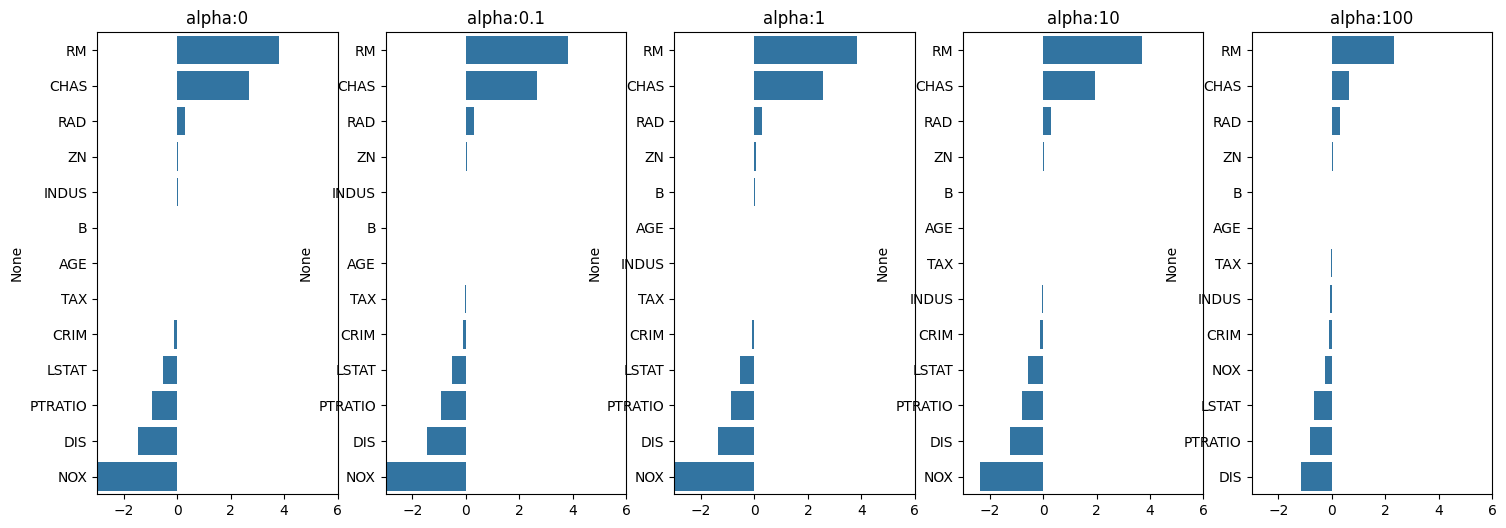

In [ ]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize=(18, 6), nrows=1, ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alpahs 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos, alpha in enumerate(alphas):
  ridge = Ridge(alpha = alpha)
  ridge.fit(X_data, y_target)
  # alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가.
  coeff= pd.Series(data=ridge.coef_, index=X_data.columns)
  colname='alpha:'+str(alpha)
  coeff_df[colname] = coeff
  # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
  coeff = coeff.sort_values(ascending=False)
  axs[pos].set_title(colname)
  axs[pos].set_xlim(-3, 6)
  sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 다른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

- 그래프를 통해 alpha 값을 증가시킬수록 회귀 계수 값은 지속적으로 작아짐을 알 수 있음 (특히 NOX 피처)

In [ ]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


- alpha 값이 증가하며 회귀 계수가 지속적으로 작아짐을 표를 통해 알 수 있음
- 릿지 회귀는 회귀 계수를 0으로 만들지 않음

### 라쏘 회귀

- W의 절댓값에 페널티를 부여하는 L1 규제를 선형 회귀에 적용
- L1 규제
  - 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거
  - 적절한 피처만 회귀에 포함시키는 피처 선택의 특성




In [ ]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
  coeff_df = pd.DataFrame()
  if verbose : print('#######', model_name, '#######')
  for param in params:
    if model_name == 'Ridge' : model = Ridge(alpha=param)
    elif model_name == 'Lasso' : model = Lasso(alpha=param)
    elif model_name == 'ElasticNet' : model = ElasticNet(alpha=param, l1_ratio=0.7)
    neg_mse_scores = cross_val_score(model, X_data_n, y_target_n,
                                     scoring="neg_mean_squared_error", cv=5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))
    # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
    model.fit(X_data, y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가.
    coeff = pd.Series(data=model.coef_, index=X_data.columns)
    colname = 'alpha:'+str(param)
    coeff_df[colname] = coeff
  return coeff_df

#end of get_linear_reg_eval

In [ ]:
# 라쏘에 사용될 alpha 파라미터의 값을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

####### Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189


- alpha가 0.07일 때 가장 좋은 평균 RMSE
- 릿지 평균(5.330)보다는 약간 떨어지는 수치

In [ ]:
# 반환된 coeff_lasso_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


- alpha의 크기가 증가함에 따라 일부 피처의 회귀 계수가 아예 0으로 바뀜
- NOX : alpha가 0.07일 때부터 회귀 계수가 0

### 엘라스틱넷 회귀

- L2 규제와 L1 규제를 결합한 회귀
- alpha값에 따라 회귀 계수의 값이 급격히 변동하는 것을 완화하기 위해 L2 규제를 라쏘 회귀에 추가
- 단점 : 수행시간이 상대적으로 오래 걸림
- 주요 파라미터 : alpha, l1_ratio

In [ ]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas,
                                       X_data_n = X_data, y_target_n = y_target)

####### ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068


In [ ]:
# 반환된 coeff_elastic_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


- alpha가 0.5일 때, RMSE 값이 가장 작으므로 예측 성능이 가장 좋

### 선형 회귀 모델을 위한 데이터 변환

- 선형 회귀 모델은 피처값과 타깃값의 분포가 '정규분포'인 형태를 매우 선호
- 타깃값의 경우 왜곡된 형태의 분포도이면 예측 성능에 부정적인 영향 미칠 가능성이 높음

  -> 선형 회귀 모델 적용 전 데이터에 대한 스케일링/정규화 작업을 수행하는 것이 일반적

[스케일링/정규화 방법]
1. StandardScaler / MinMaxScaler
  - StandardScaler : 평균이 0, 분산이 1인 정규 분포
  - MinMaxScaler : 최솟값이 0이고, 최댓값이 1인 값으로 정규화
2. 스케일링/정규화 수행 후 다항 특성 적용하여 변환
  - 1번 진행 후 예측 성능에 향상이 없으면 적용
3. 로그 변환
  - 타깃값의 경우 일반적으로 로그 변환 적용
  - 다른 정규값으로 변환하면 원본 타깃값으로 되돌리기 어려움
  - 왜곡된 분포도를 가진 타깃값을 로그 변환했을 때, 많은 사례에서 예측 성능 향상


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
import numpy as np

# method는 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다항식 특성을 추가할 때 적용, p_degree는 2 이상 부여하지 않음.

def get_scaled_data(method='None', p_degree=None, input_data=None):
  if method == 'Standard' :
    scaled_data = StandardScaler().fit_transform(input_data)
  elif method == 'MinMax' :
    scaled_data = MinMaxScaler().fit_transform(input_data)
  elif method == 'Log' :
    scaled_data = np.log1p(input_data)
  else:
    scaled_data = input_data


  if p_degree != None:
    scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(input_data)

  return scaled_data

- 언더 플로우 발생을 막기 위해 np.log()가 아닌 np.log1p() 사용

In [ ]:
# Ridge의 alpha 값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출.
alphas = [0.1, 1, 10, 100]

# 5개 방식으로 변환. 먼저 원본 그대로, 표준정규 분포, 표준정규 분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환
scale_methods = [(None, None), ('Standard', None), ('Standard', 2),
                 ('MinMax', None), ('MinMax', 2), ('Log', None)]
for scale_method in scale_methods :
  X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1],
                                  input_data=X_data)
  print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
  get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled,
                      y_target_n=y_target, verbose=False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 9.141
alpha 1일 때 5 폴드 세트의 평균 RMSE: 8.938
alpha 10일 때 5 폴드 세트의 평균 RMSE: 10.556
alpha 100일 때 5 폴드 세트의 평균 RMSE: 10.566

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 9.141
alpha 1일 때 5 폴드 세트의 평균 RMSE: 8.938
alpha 10일 때 5 폴드 세트의 평균 RMSE: 10.556
alpha 100일 때 5 폴드 세트의 평균 RMSE: 10.566

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 4

- alpha가 0.1, 1, 10일 때, 로그 변환에서 좋은 성능 향상

## 5-7. 로지스틱 회귀

선형 회귀 방식을 '분류'에 적용한 알고리즘



- 선형 회귀와 차이점 :

  학습을 통해 선형 함수의 회귀 최적선을 찾는 것이 아닌, 시그모이드 함수 최적선을 찾고 시그모이드 함수의 반환 값을 확률로 간주하여 확률에 따라 분류

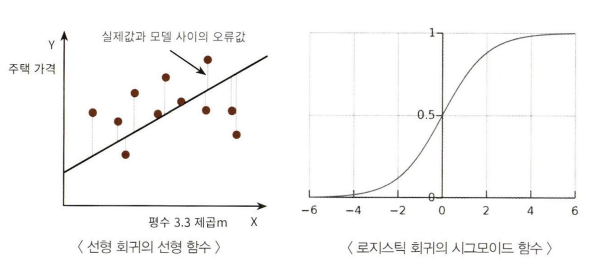

- 시그모이드 함수는 x값이 아무리 커지거나 작아져도 y 값이 항상 0~1 사이에 존재

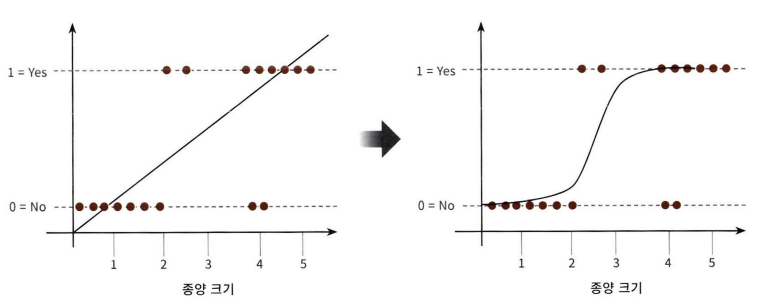

- 선형 회귀를 사용하여 분류하면 회귀선이 0과 1을 제대로 분류하지 못함(정확도가 떨어짐)
- S자 커브 형태의 시그모이드 함수를 이용하면 좀 더 정확하게 분류 가능

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler()로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target,
                                                    test_size=0.3, random_state=0)

- 로지스틱 회귀는 데이터의 정규 분포도에 따라 예측 성능 영향을 받을 수 있으므로 표준 스케일링 적용

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용해 학습 및 예측 수행.
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

# 정확도와 roc_auc 측정
print('accuracy: {0:.3f}'.format(accuracy_score(y_test, lr_preds)))
print('roc_auc: {0:.3f}'.format(roc_auc_score(y_test, lr_preds)))

accuracy: 0.977
roc_auc: 0.972


In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'penalty' : ['l2', 'l1'],
          'C' : [0.01, 0.1, 1, 5, 10]}
grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 1, 'penalty': 'l2'}, 최적 평균 정확도:0.975


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

[LogisticRegression 주요 하이퍼 파라미터]
- penalty : 규제의 유형 설정 (default='l2')
- C : 규제 강도를 조절, alpha값의 역수 / C값이 작을수록 규제 강도가 커짐